In [10]:
# https://www.kaggle.com/datasets/datasnaek/chess?resource=download
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 10)

df = pd.read_csv("datasets/chess_games.csv")
df = df[df["rated"] == True]

df = df.drop(
    ["id", "rated", "created_at", "last_move_at", "white_id", "black_id", "moves"], 
    axis=1).reset_index(drop=True)
df

,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_eco,opening_name,opening_ply
0,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,4
1,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,3
2,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,3
3,95,mate,white,30+3,1523,1469,C41,Philidor Defense,5
4,33,resign,white,10+0,1520,1423,D00,Blackmar-Diemer Gambit: Pietrowsky Defense,10
...,...,...,...,...,...,...,...,...,...
16150,24,resign,white,10+10,1691,1220,A80,Dutch Defense,2
16151,82,mate,black,10+0,1233,1196,A41,Queen's Pawn,2
16152,35,mate,white,10+0,1219,1286,D00,Queen's Pawn Game: Mason Attack,3
16153,109,resign,white,10+0,1360,1227,B07,Pirc Defense,4


In [12]:
# Generalize time format by ignoring the increment time
df["increment_code"] = df["increment_code"].map(lambda el: el.split("+")[0])
# Replace matches with "0" time 
df["increment_code"] = df["increment_code"].replace("0", "no time limit")

# Generalize openings by ignoring the opening variation (prefixed by ":") and drop records that contain multiple openings (drop if "|")
df["opening_name"] = df["opening_name"].map(lambda el: None if "|" in el else el.split(":")[0])
df.dropna(axis=0, inplace=True)

In [13]:
df.nunique()

turns              208
victory_status       4
winner               3
increment_code      33
white_rating      1416
black_rating      1437
opening_eco        222
opening_name       164
opening_ply         17
dtype: int64

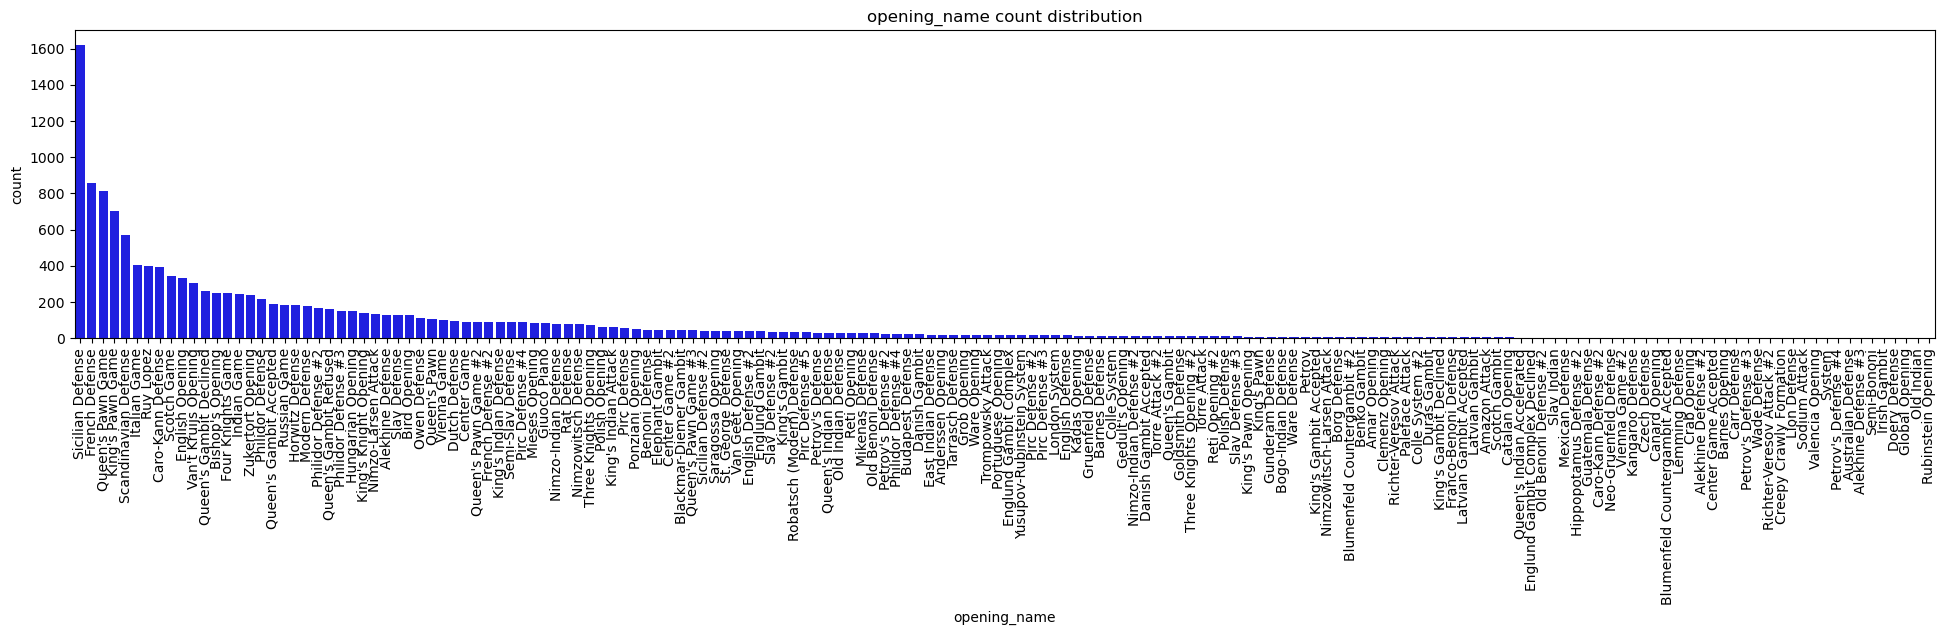

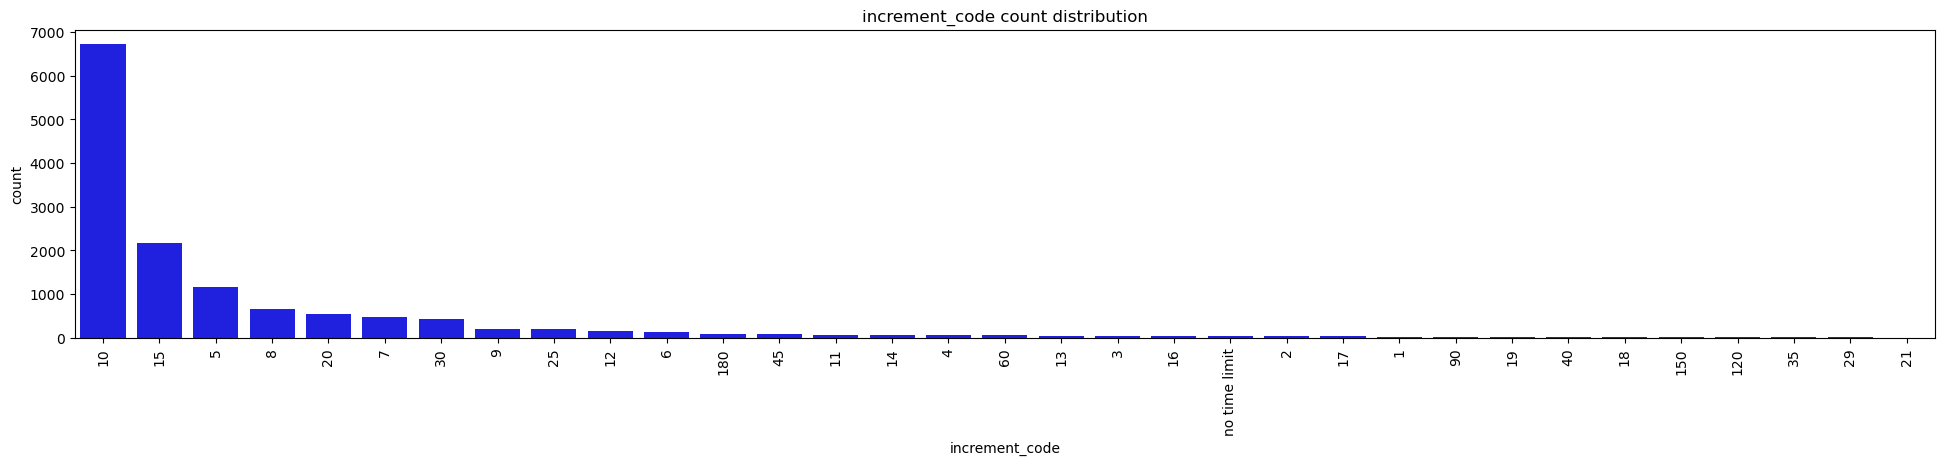

In [14]:
def plot_cat_col(col_name: str, size: tuple):
    _, ax = plt.subplots(figsize=size)
    ax = sns.countplot(x=col_name, color='blue', data=df, order = df[col_name].value_counts().index)
    ax.set_title(f"{col_name} count distribution")
    plt.xticks(rotation=90)
    plt.show()

plot_cat_col('opening_name', (24, 4))
plot_cat_col('increment_code', (24, 4))

In [15]:
def reduce_value_count(df: pd.DataFrame, n: int, feature_name: str):
    top_n = df[feature_name].value_counts().index[:n]
    df[feature_name] = np.where(
        df[feature_name].isin(top_n), 
        df[feature_name],
        None)

reduce_value_count(df, 10, "opening_name")
reduce_value_count(df, 3, "increment_code")
df.nunique()

turns              208
victory_status       4
winner               3
increment_code       3
white_rating      1416
black_rating      1437
opening_eco        222
opening_name        10
opening_ply         17
dtype: int64

In [17]:
df.dropna(axis=0, inplace=True)
df

,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_eco,opening_name,opening_ply
1,61,mate,white,5,1496,1500,C20,King's Pawn Game,3
5,66,resign,black,15,1439,1392,C50,Italian Game,6
6,119,mate,white,10,1381,1209,B01,Scandinavian Defense,4
8,13,resign,black,10,1113,1423,B21,Sicilian Defense,3
9,69,mate,white,10,1078,1219,D01,Queen's Pawn Game,4
...,...,...,...,...,...,...,...,...,...
16146,43,mate,white,10,1328,1252,C00,French Defense,5
16147,9,outoftime,white,10,1243,1142,A20,English Opening,2
16148,58,mate,black,10,1237,1231,C00,French Defense,3
16152,35,mate,white,10,1219,1286,D00,Queen's Pawn Game,3


- Time format? df["increment_code"] 4 states
- Black rating? df["black_rating"] bins 6
- White rating? df["white_rating"] bins 6
- Opening? df["opening_name"] 11 states
- Number of turns? df["turns"] range[1-350]
- Winner? df["winner"] 3 states {black, white, draw}
- Victory status? df["victory_status"] 4 states {'resign', 'mate', 'draw', 'outoftime'}

In [32]:
import pyAgrum as gum
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
import pyAgrum.lib.notebook as gnb

tfmt_unique = df["increment_code"].unique()
tfmt_unique.sort()
tfmt_states = "|".join(tfmt_unique.tolist())

op_unique = df["opening_name"].unique()
op_unique.sort()
op_states = "|".join(op_unique.tolist())
rating_bins = "|".join([f"({x}, {x+500}]" for x in range(0, 3000, 500)])

victory_status_unique = df["victory_status"].unique()
victory_status_unique.sort()
victory_states = "|".join(victory_status_unique.tolist())

bn = gum.fastBN(
    f"Time format?{{{tfmt_states}}}->White rating?{{{rating_bins}}}->Opening?{{{op_states}}}<-Black rating?{{{rating_bins}}}<-Time format?->Number of turns?[1, 350];"
    f"Opening?->Winner?{{black|white|draw}}<-Number of turns?;"
    f"Winner?->Victory status?{{{victory_states}}}"
)

bn

(pyAgrum.BayesNet<double>@0x2798baa0880) BN{nodes: 7, arcs: 8, domainSize: 10^6.65667, dim: 8412, mem: 93Ko 456o}

Compute table for $p(\text{Time format})$

In [33]:
# prior over RV "Time format?"
time_distr = df["increment_code"].value_counts(normalize=True).sort_index()
bn.cpt("Time format?").fillWith(time_distr)

(pyAgrum.Potential<double>@0x2798badc520) 
  Time format?               |
5        |10       |15       |
---------|---------|---------|
 0.6699  | 0.2178  | 0.1123  |

Compute table for $p(\text{White rating} | \text{Time format})$ and $p(\text{Black rating} | \text{Time format})$

In [34]:
bins = [0, 500, 1000, 1500, 2000, 2500, 3000]

for i, state in enumerate(tfmt_unique):
    # Compute and set p(white_rating | time_format)
    white_rating_bins = pd.cut(df[df["increment_code"] == state]["white_rating"], bins=bins)
    wr_probs = white_rating_bins.value_counts() / white_rating_bins.count()
    wr_probs = wr_probs.sort_index()
    bn.cpt("White rating?")[i, :] = wr_probs.to_numpy()

    # Compute and set p(black_rating | time_format)
    black_rating_bins = pd.cut(df[df["increment_code"] == state]["black_rating"], bins=bins)
    br_probs = black_rating_bins.value_counts() / black_rating_bins.count()
    br_probs = br_probs.sort_index()
    bn.cpt("Black rating?")[i, :] = br_probs.to_numpy()

In [35]:
gnb.sideBySide(bn.cpt("White rating?"), bn.cpt("Black rating?"))

Compute table for $p(\text{Opening} | \text{White rating}, \text{Black rating})$

In [36]:
bin_range = range(0, 3000, 500)

for wi, i in enumerate(bin_range):
    for bi, j in enumerate(bin_range):
        conditioned = df[
            (df["white_rating"] > i) & (df["white_rating"] <= i+500) &
            (df["black_rating"] > j) & (df["black_rating"] <= j+500)]["opening_name"].sort_index()
        
        zero_op_vec = pd.Series(np.zeros(len(op_unique), ), op_unique)
        
        op_probs = (zero_op_vec + conditioned.value_counts(normalize=True)).fillna(0)
        
        if 1 - op_probs.sum() > 0.001:
            uniform = np.ones(len(op_unique), ) / len(op_unique)
            bn.cpt("Opening?")[bi, wi, :] = uniform
        else:
            bn.cpt("Opening?")[bi, wi, :] = op_probs.to_numpy()

In [37]:
bn.cpt("Opening?")

(pyAgrum.Potential<double>@0x2798badc400) 
             ||  Opening?                                                                                         |
White |Black ||Caro-Kann|English O|French De|Italian G|King's Pa|Queen's P|Ruy Lopez|Scandinav|Scotch Ga|Sicilian |
------|------||---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
(0, 50|(0, 50|| 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  |
(500, |(0, 50|| 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  |
(1000,|(0, 50|| 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  |
(1500,|(0, 50|| 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  |
(2000,|(0, 50|| 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  |
(2500,|(0, 50|| 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  |
[...24 more line(s) ...]
(0, 50|(2500,|| 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  |
(500, |(2500,|| 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  |
(1000,|(2500,|| 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  |
(1500,|(2500,|| 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  |
(2000,|(2500,|| 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  |
(2500,|(2500,|| 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  | 0.1000  |

Compute table for $p(\text{Turns} | \text{Time format})$

In [38]:
for i, state in enumerate(tfmt_unique):
    conditioned = df[df["increment_code"] == state]["turns"].sort_index()
    
    zero_turn_vec = pd.Series(np.zeros(350, ))
    
    turn_probs = (zero_turn_vec + conditioned.value_counts(normalize=True)).fillna(0)
    bn.cpt("Number of turns?")[i, :] = turn_probs.to_numpy()

In [39]:
bn.cpt("Number of turns?")

(pyAgrum.Potential<double>@0x2798badc1e0) 
      ||  Number of turns?                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
Time f||1        |2        |3        |4        |5        |6        |7        |8        |9        |10       |11       |12       |13       |14       |15       |16       |17       |18       |19       |20       |21       |22       |23       |24       |25       |26       |27       |28       |29       |30       |31       |32       |33       |34       |35       |36       |37       |38       |39       |40       |41       |42       |43       |44       |

Compute table for $p(\text{Winner} | \text{Opening}, \text{Turns})$

In [40]:
winner_states = ["black", "white", "draw"]

for op_i, op_name in enumerate(op_unique):
    for ti, turn in enumerate(range(1, 351)):
        conditioned = df[
            (df["opening_name"] == op_name) & 
            (df["turns"] == turn)]["winner"].sort_index()
        
        zero_winner_vec = pd.Series(np.zeros(len(winner_states), ), winner_states)
    
        winner_probs = (zero_winner_vec + conditioned.value_counts(normalize=True)).fillna(0)
        if winner_probs.sum() == 0:
            uniform = np.ones(len(winner_states), ) / len(winner_states)
            bn.cpt("Winner?")[ti, op_i, :] = uniform
        else:
            bn.cpt("Winner?")[ti, op_i, :] = winner_probs.to_numpy()

Compute table for $p(\text{Victory status} | \text{Winner})$

In [41]:
for win_i, win in enumerate(winner_states):
    
    conditioned = df[df["winner"] == win]["victory_status"].sort_index()
    
    zero_vs_vec = pd.Series(np.zeros(len(victory_status_unique), ), victory_status_unique)
    victory_probs = (zero_vs_vec + conditioned.value_counts(normalize=True)).fillna(0)

    if victory_probs.sum() == 0:
        uniform = np.ones(len(victory_status_unique), ) / len(victory_status_unique)
        bn.cpt("Winner?")[ti, op_i, :] = uniform
    else:
        bn.cpt("Victory status?")[win_i, :] = victory_probs.to_numpy()

In [42]:
bn.cpt("Victory status?")

(pyAgrum.Potential<double>@0x2798badbea0) 
      ||  Victory status?                      |
Winner||draw     |mate     |outoftime|resign   |
------||---------|---------|---------|---------|
black || 0.0000  | 0.3493  | 0.0878  | 0.5629  |
white || 0.0000  | 0.3482  | 0.0817  | 0.5701  |
draw  || 0.9239  | 0.0000  | 0.0761  | 0.0000  |

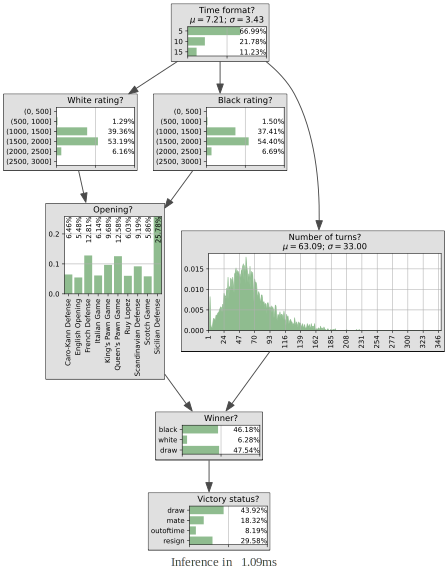

In [43]:
gnb.showInference(bn, evs={})

Question: Given a game of `Rapid chess` (15 minute games) and the black player won, what is the probability of winning by mate?

$p(\text{Victory status}=mate | \text{Time format}=15, \text{Winner}=black)$

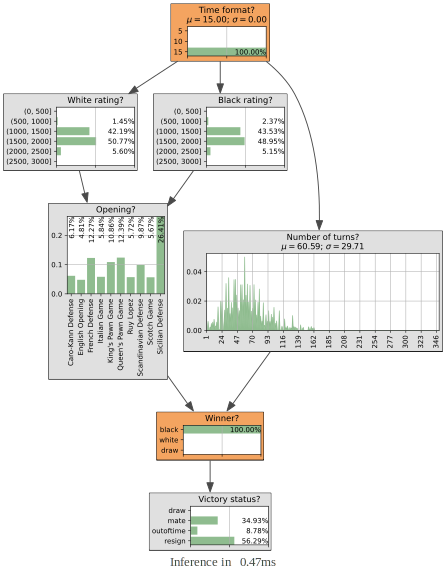

In [44]:
gnb.showInference(bn, evs={"Time format?": "15", "Winner?": "black"})

Question: Alice is a casual chess player with an ELO rating of around 1200. She likes to take walks through the parks of New York City. One day she encounters Bob who sits in Central Park and plays chess against passing people. Alice wants to play against Bob to test her skill. However, Alice is aware of these so-called "chess hustlers" who downplay their true rating. She suspects Bob to have a higher ELO rating in the range of [1500-2000]. Alice gets the white pieces, and Bob the black pieces. They play a blitz game (5 minute format). What is the probability that Alice wins as white, given her rating and her suspicion about Bob?

$p(\text{Winner}=white | \text{Time format}=5, \text{White rating}=(1000, 1500], \text{Black rating}=(1500, 2000])$

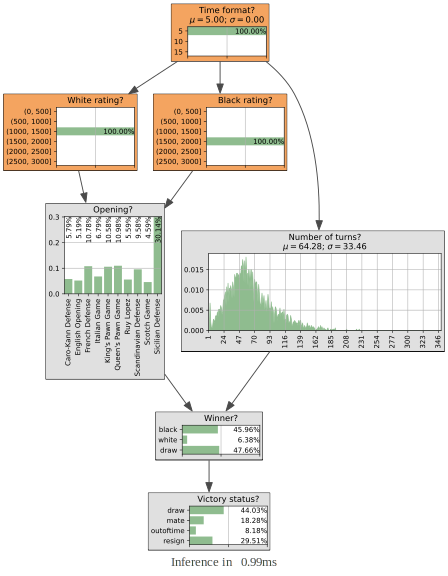

In [45]:
gnb.showInference(bn, evs={"Time format?": "5", "White rating?": "(1000, 1500]", "Black rating?": "(1500, 2000]"})

Question: 

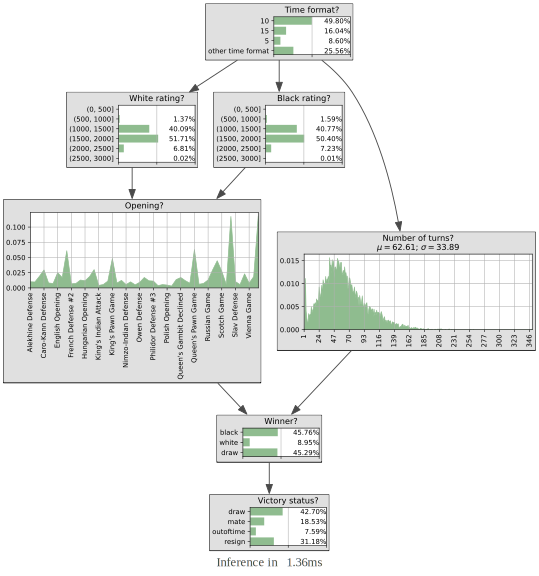

In [160]:
normal_curve = lambda x, mean, std: 1/(std*(2*np.pi)) * np.exp(-.5 * ((x-mean)/std)**2)

turn_x = np.linspace(1, 350, 350)
turn_mean = 10
turn_std  = 40
turn_soft_evidence_vec = normal_curve(turn_x, turn_mean, turn_std)

gnb.showInference(bn, evs={})
# gnb.showInference(bn, evs={"White rating?": "(1000, 1500]", "Black rating?": "(1000, 1500]"})